# Showcasing how Benders decomposition works via a simple MPC problem.

This notebook implements a 1-dimensional 1-step MPC problem to showcase how Benders decomposition works for continuous complicating variables. 

#### Problem setting

\begin{align*}
\mathcal{P}(x):= \min \quad & Q (x^+)^2 + R u^2\\ 
s.t. \quad & x^+ = Ax + Bu\\ 
& u \in \mathbb{R}, \quad x^+ \in \mathbb{R}
\end{align*}

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from matplotlib import cm

Q = 1
R = 1
A = 3
B = 2.5
solver = SolverFactory('ipopt')

#### Master Problem (MP)

The MP determines the control input $u$ and approximates its effects to the dynamic system. The calculated control input will then be evaluated in the subproblem. 

\begin{align*}\min \quad &  R u^2 + \eta\\ 
s.t. \quad & \eta \ge \mathcal{S}(u^l) + \lambda^l(u-u^l) \quad \forall l \in \mathcal{L}\\ 
& u \in \R, \quad \eta \in \R_+
\end{align*}

In [135]:
def mp_create():
    mp = ConcreteModel()
    mp.u = Var(initialize=0.1)
    mp.eta = Var(initialize=1, within=NonNegativeReals)

    def input_cost_rule(mp):
        return R * mp.u**2
    mp.input_cost = Expression(expr=input_cost_rule)
    mp.benders_cuts = ConstraintList()
    mp.mp_obj = Objective(expr=mp.input_cost+mp.eta)

    return mp

mp1 = mp_create()
mp2 = mp_create()

#### Subproblem (SP)

The subproblem evaluates the effects of the given control input $u$. 

\begin{align*}\mathcal{S}(u) = \min \quad &  Q (x^+)^2\\ 
s.t. \quad & x^+ = Ax + Bu \\ 
& u = \bar u:\ \lambda \\
& \bar{u} \in \R, \quad x^+ \in \R
\end{align*}

In [136]:
def sp_create():
    sp = ConcreteModel()
    sp.x = Param(initialize=0.5)
    sp.u_bar = Var(initialize=0.1)
    sp.x_plus = Var(initialize=0.1)
    sp.u = Param(initialize=0.1, mutable=True)
    sp.dual = Suffix(direction=Suffix.IMPORT)
    def dynamics_rule(sp):
        return sp.x_plus == A*sp.x + B*sp.u_bar
    sp.dynamics = Constraint(rule=dynamics_rule)

    def fix_input_rule(sp):
        return sp.u == sp.u_bar
    sp.fix_input = Constraint(rule=fix_input_rule)

    def state_cost(sp):
        return Q * ((sp.x_plus-0.2)**2 + (sp.x-0.2)**2)
    sp.sp_obj = Objective(expr=state_cost)

    return sp

sp1 = sp_create()
sp2 = sp_create()

#### Visualize the value function $\mathcal{S}(u)$.

Actually it's just a quadratic function!

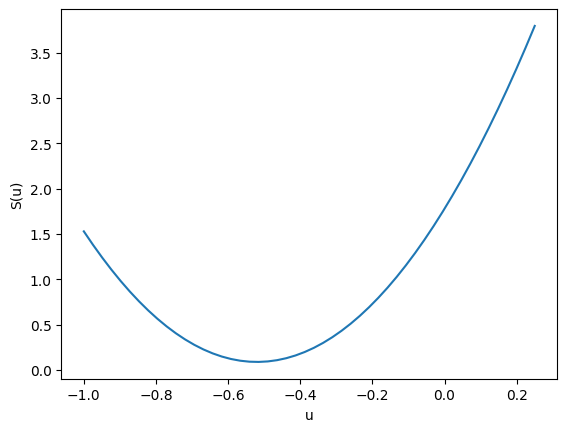

In [137]:
# sp.u_bar = value(mp.u)
us = np.linspace(-1.0, 0.25, 50)
sp_objs = np.zeros_like(us)
for i, u in enumerate(us):
    sp1.u = u
    solver.solve(sp1)
    sp_objs[i] = value(sp1.sp_obj)
    
plt.plot(us, sp_objs)
plt.xlabel('u')
plt.ylabel('S(u)')
plt.show()
#plt.legend()


#### Generalized Benders decomposition implementation

In [138]:
benders_cutting_planes1 = {}
benders_cutting_planes2 = {}

def benders_one_step(mp, sp, benders_cutting_planes, u=None):   
    # 1. Solve MP for u
    if u == None:
        solver.solve(mp)
        sp.u = value(mp.u)
    else: 
        sp.u = u

    # 2. Solve SP, extract dual and add the benders cut
    solver.solve(sp)
    dual_val = sp.dual[sp.fix_input]
    phi = value(sp.sp_obj)
    u_value = sp.u_bar.value
    benders_cut = phi + dual_val * (mp.u - u_value)
    # print("Benders cut:", benders_cut)

    def benders_cutting_plane(u):
        return phi + value(dual_val) * (u - u_value)

    benders_cutting_planes[u_value] = benders_cutting_plane

    mp.benders_cuts.add(mp.eta >= benders_cut)

#### Run GBD for 8 iterations.

Here we compare the performance of GBD with and without initialization.

/var/folders/3z/x9m88lh93kd051j9_hsfy05m0000gn/T/ipykernel_30888/2379713926.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


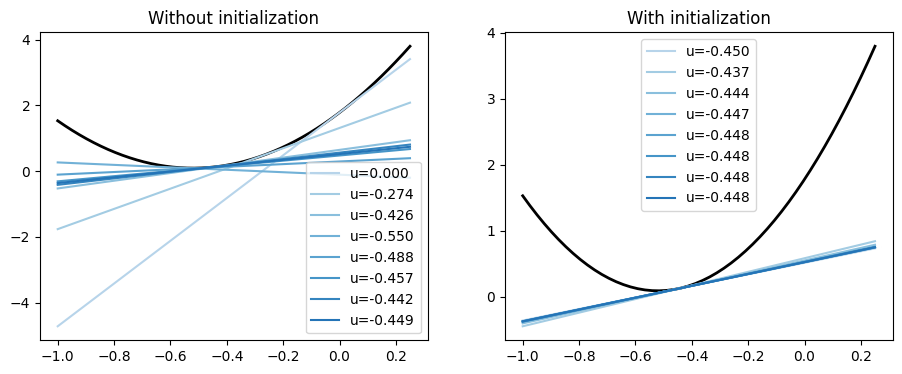

In [139]:
for i in range(8):
    # Left: Without initialize
    benders_one_step(mp1, sp1, benders_cutting_planes1)
    
    # Right: With initialize
    if i == 0:
        u = -0.45
    else:
        u = None
    benders_one_step(mp2, sp2, benders_cutting_planes2, u=u) # , u=-0.4483

cmap = cm.get_cmap('Blues')
colors = [cmap(0.3 + 0.5 * i / len(benders_cutting_planes1)) for i in range(len(benders_cutting_planes1))]

fig, ax = plt.subplots(1, 2, figsize=(11,4))

ax[0].plot(us, sp_objs, color='black', linewidth=2)
for (u_val, cut), color in zip(benders_cutting_planes1.items(), colors):
    ax[0].plot(us, cut(us), color=color, label=f'u={u_val:.3f}')
ax[0].legend()
ax[0].set_title('Without initialization')

ax[1].plot(us, sp_objs, color='black', linewidth=2)
for (u_val, cut), color in zip(benders_cutting_planes2.items(), colors):
    ax[1].plot(us, cut(us), color=color, label=f'u={u_val:.3f}')
ax[1].legend()
ax[1].set_title('With initialization')

plt.show()

#### Visualize the piecewise affine function used in MP to approximate value function $\mathcal{S}(u)$.

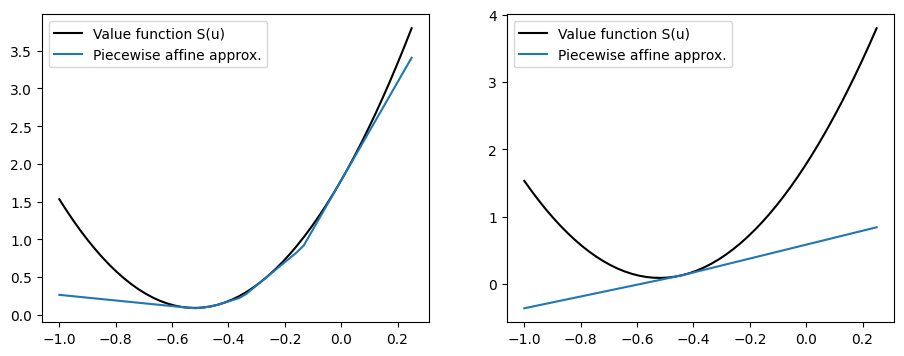

In [140]:
def outer_approx(benders_cutting_planes):
    under_estimate_function = lambda u: max([plane(u) for plane in benders_cutting_planes.values()])
    under_estimate = []
    for u in us:
        under_estimate.append(under_estimate_function(u))
    return under_estimate

fig, ax = plt.subplots(1, 2, figsize=(11,4))

ax[0].plot(us, sp_objs, c='k', label='Value function S(u)')
ax[0].plot(us, outer_approx(benders_cutting_planes1), label=f'Piecewise affine approx.')
ax[0].legend()

ax[1].plot(us, sp_objs, c='k', label='Value function S(u)')
ax[1].plot(us, outer_approx(benders_cutting_planes2), label=f'Piecewise affine approx.')
ax[1].legend()

plt.show()

**Conclusion:**
1. GBD converges much faster with proper warm-start.
2. We actually don't need a very tight approximation in order to obtain the optimal solution (if the starting point works so well). 